<a href="https://colab.research.google.com/github/krystaldowling/MAST30034_Final_Project-/blob/LSTM/LSTM_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/Data/final_preproccessed_data.csv', lineterminator='\n')

In [ ]:
def tokeniser(data, max_len=500):

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data['text'])
  # dictonary of all words in data and counts
  word_index = tokenizer.word_index
  # number of words in all articles in dataset
  vocab_size=len(word_index)
  sequences = tokenizer.texts_to_sequences(data['text'])
  # padding data
  padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

  return padded, vocab_size, word_index

In [ ]:
padded, vocab_size, word_index = tokeniser(data)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  sklearn.model_selection.train_test_split(padded, data['label'],test_size = 0.2, random_state = 20)

In [ ]:

# Import tensor representations for words

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-10-14 00:39:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  79.1MB/s    in 4.2s    

2020-10-14 00:39:50 (79.1 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

100


In [ ]:
# the classic LSTM model

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,100, weights=[embeddings_matrix],trainable=False),
    tf.keras.layers.Dropout(0.2),
    # 1 x 5 filter for the convolutional layer as each sample is a vector
    tf.keras.layers.Conv1D(32, 5, activation='relu',padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 3, activation='relu',padding='same'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model_lstm.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 100)         23440100  
_________________________________________________________________
dropout_41 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 32)          16032     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
dropout_42 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 64)          6208      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, None, 64)        

In [ ]:
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

# important to note that default shuffle is set to true so the NN doesn't memorise a sequence and increases generability
history = model_lstm.fit(X_train, y_train, epochs=20, batch_size=50, validation_data=(X_test, y_test))

print("Training Complete")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         23440100  
_________________________________________________________________
dropout_38 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, None, 32)          16032     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
dropout_39 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 64)          6208      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, None, 64)        

In [ ]:
# Bi-directional LSTM model
model_bi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,100, weights=[embeddings_matrix],trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(32, 5, activation='relu',padding = 'same'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 3, activation='relu',padding = 'same'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    #tf.keras.layers.Bidirectional(LSTM(10, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(20)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_bi_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_bi_lstm.summary()

# important to note that default shuffle is set to true so the NN doesn't memorise a sequence and increases generability
history = model_bi_lstm.fit(X_train, y_train, epochs=15, batch_size=50, validation_data=(X_test, y_test))

print("Training Complete")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 100)         23440100  
_________________________________________________________________
dropout_31 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 32)          16032     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
dropout_32 (Dropout)         (None, None, 32)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 64)          6208      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, None, 64)         

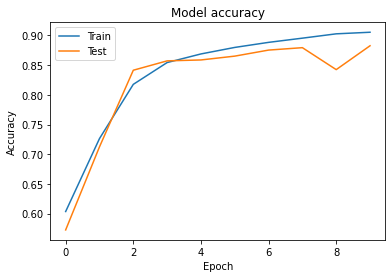

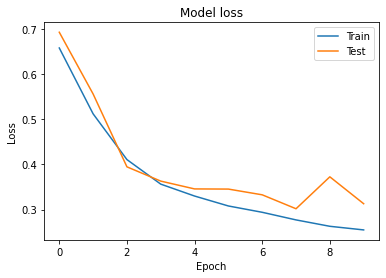

In [ ]:

# Visualize the results:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()